In [233]:
import numpy as np
import pandas as pd
from datetime import datetime
import igraph

import networkx as nx 
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

import matplotlib.pyplot as plt

# Main steps: 
* Load data
* Divide into test-train

##  1. Load data

In [234]:
filepath= './data/'

# covid
covid_df = pd.read_csv(filepath + '/covid19-US.csv')

# flights
flight_feb19 = pd.read_csv(filepath + '/flights-feb19.csv')
flight_mar19 = pd.read_csv(filepath + '/flights-mar19.csv')
flight_apr19 = pd.read_csv(filepath + '/flights-apr19.csv')

flights_list = [flight_feb19, flight_mar19, flight_apr19] 

### 1.1. Create DataFrame (cleaned)

In [235]:
def load_flights(mylist):
    
    '''input: list containing raw dataframe of flights for each months
       output: full flight dataframe cleaned'''
    
    elements = []
    
    for i, element in enumerate(mylist): 
        element['origin_state'] = element.ORIGIN_CITY_NAME.apply(lambda x: x.strip().split()[-1])
        element['dest_state'] = element.DEST_CITY_NAME.apply(lambda x: x.strip().split()[-1])
        element = element.drop(element.columns[[1,2,3,4,6,7,10]] , axis = 1)
        element['day'] = element['FL_DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)
        element['month'] = element['FL_DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
        element['flights'] = element['FLIGHTS']
        element = element.drop(['ORIGIN_STATE_NM', 'DEST_STATE_NM', 'FLIGHTS'], axis = 1)
        elements.append(element)
        
    df = pd.concat(elements)
    return df

flights = load_flights(flights_list)
flight_df = flights.groupby(['day', 'month', 'origin_state', 'dest_state'])['flights'].sum().reset_index().fillna(0)

In [238]:
state_abbreviations_df = pd.read_csv(filepath + 'state_abbreviations.csv' )
abbreviations_dict = dict(zip(state_abbreviations_df.State, state_abbreviations_df.Code)) 

covid_df['day'] = covid_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)
covid_df['month'] = covid_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
covid_df['origin_state'] = covid_df.state.apply(lambda x: abbreviations_dict[x] if x in abbreviations_dict.keys() else 'other')
covid_df = covid_df.drop(['fips', 'state'], axis = 1)

### 1.2. Divide into train-test

In [239]:
from sklearn.model_selection import train_test_split
flights_train, flights_test = train_test_split(flights, test_size=0.2, shuffle = False)

The function 'train_test_split' results in a split in the middle of a day (13th april is divided between train and test). This will results in misscalculations hence the split is redefined so that the test sample includes the 13th april (and the train does not include it). 

In [240]:
mask = flights['FL_DATE'] < '2019-04-13'
flights_train = flights[mask]
flights_test = flights[~ mask]

In [241]:
flights_train = flights_train.groupby(['month','day','origin_state','dest_state']).sum()
flights_test = flights_test.groupby(['month','day','origin_state','dest_state']).sum()

### 1.3. Initial status configuration

#### Data

In [242]:
day = 1
month = 3

interesting_flight_data = flight_df.loc[(flight_df.day == day) & (flight_df.month == month)]

interesting_covid_data = covid_df.loc[(covid_df.day == day) & (covid_df.month == month)]
interesting_covid_data = interesting_covid_data.groupby(['origin_state'])['deaths', 'cases'].sum().reset_index().fillna(0)
interesting_covid_data['binary'] = np.where(interesting_covid_data['cases']> 0, 1, 0)

interesting_data = interesting_flight_data.merge(interesting_covid_data, left_on = ['origin_state'], right_on = ['origin_state'] )

print('Flight-data-of-interest shape:', interesting_flight_data.shape)
print('Covid-data-of-interest shape:', interesting_covid_data.shape)

Flight-data-of-interest shape: (1208, 5)
Covid-data-of-interest shape: (13, 4)


C:\Users\Camille\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


#### Graph
The graph is defined from the abbreviation dictionnary (51 state + other), edges have weights equal to the fraction of the number of flight from one state to the other over maximum flights, no weights is attributed to nodes. 

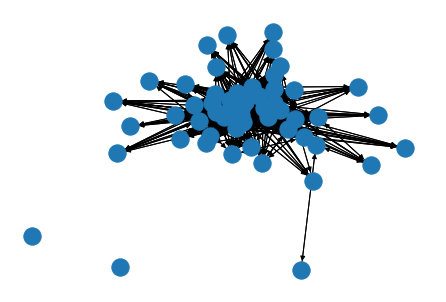

In [243]:
edge_weights = [i / np.max(interesting_flight_data.flights) for i in interesting_flight_data.flights]
nodes = list(abbreviations_dict.values()) + ['other']

# define graph
binary_graph = nx.DiGraph()

# add nodes
binary_graph.add_nodes_from(nodes)

# add edges
cases_dict = dict(zip(interesting_covid_data.origin_state, interesting_covid_data.binary))

for origin, dest, weight in zip(interesting_flight_data.origin_state, interesting_flight_data.dest_state, edge_weights):
    binary_graph.add_edge(origin, dest, weight = weight)

# draw graph
nx.draw(binary_graph)

### 3.2. SEIS model 
#### Initial status

In [244]:
# model selection
model = ep.SEISModel(binary_graph)

# model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.5) # probability of infection
cfg.add_model_parameter('lambda', 0.005) # probability of healing / removal
cfg.add_model_parameter('alpha', 0.05) # incubation period (over number of iterations)
#cfg.add_model_parameter("fraction_infected", 0.05) - initial state not needed if configured

infected_nodes = np.where(interesting_covid_data['binary'] == 1)[0]
infected_nodes = interesting_covid_data['origin_state'][infected_nodes].tolist()
cfg.add_model_initial_configuration("Infected", infected_nodes)

model.set_initial_status(cfg)

# simulation execution
iterations = model.iteration_bunch(2)

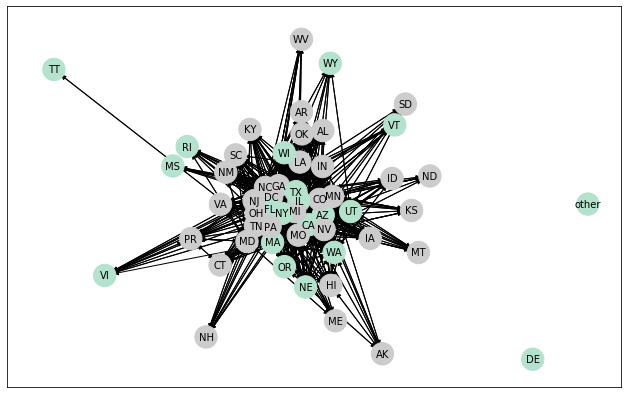

In [245]:
time = 1
val_map = iterations[time]['status']
values = [val_map.get(node, 0.45) for node in binary_graph.nodes()]

plt.figure(figsize=(11,7))
pos = nx.spring_layout(binary_graph)
nx.draw_networkx_nodes(binary_graph, pos, node_color = values, node_size = 500, cmap=plt.get_cmap('Pastel2'))
nx.draw_networkx_labels(binary_graph, pos, font_size=10, font_family='sans-serif')
black_edges = [edge for edge in binary_graph.edges()]
nx.draw_networkx_edges(binary_graph, pos, edgelist=black_edges)
                       
plt.show()

### 3.3. City level analysis

In [246]:
# group by state
state_covid = covid_df.groupby(['date', 'origin_state']).sum().reset_index().drop(['day', 'month'], axis = 1)

# select a state
state = 'NY'
state_covid = state_covid[state_covid.origin_state == 'NY']

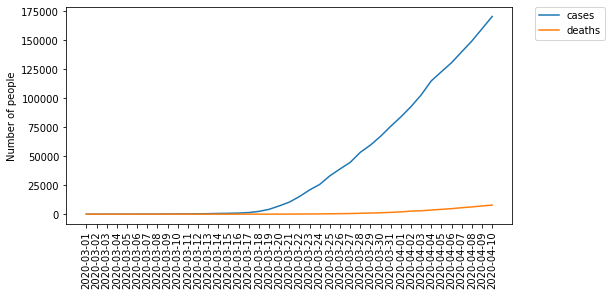

In [284]:
plt.figure(figsize=(8,4))
plt.plot(state_covid.date, state_covid.cases, label = "cases")
plt.plot(state_covid.date, state_covid.deaths, label = "deaths")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad = 0.)
plt.xticks(rotation=90)
plt.ylabel("Number of people")

plt.show()

In [325]:
population = 8.399 * 10 **(6) # NY population
i0, r0 = 421, 0
e0 = 421 * 2.5 # exposed number > DEFINE NUMBER
s0 = population - e0 - i0 - r0 # susceptible population

In [326]:
incubation_duration = 4 # based on paper
# recovery_duration = 10 # a guess
infectious_duration = 3.6 # based on paper

beta = 1.07 # rate of spread; based on paper
sigma = 1 / incubation_duration # incubation rate
gamma = 1 / infectious_duration # recovery rate

In [327]:
n_days = 90

In [328]:
def deriv(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = - beta * S * I / N
    dEdt = beta * S * I / N - sigma * E 
    dIdt = sigma * E - gamma * I  # mathematically correct to add imported_infection constant?
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [309]:
from scipy.integrate import odeint
t = np.linspace(0, n_days, n_days)
# initial conditions vector
y0 = s0, e0, i0, r0
# integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(population, beta, sigma, gamma))
S, E, I, R = ret.T

In [323]:
date_start = datetime.strptime('2020-03-13', '%Y-%m-%d')
datelist = pd.date_range(date_start,periods=n_days).to_list()
dates = [str(d.date()) for d in datelist]

In [364]:
dates_real = state_covid[state_covid['date'] < '2020-04-11'].date.tolist()

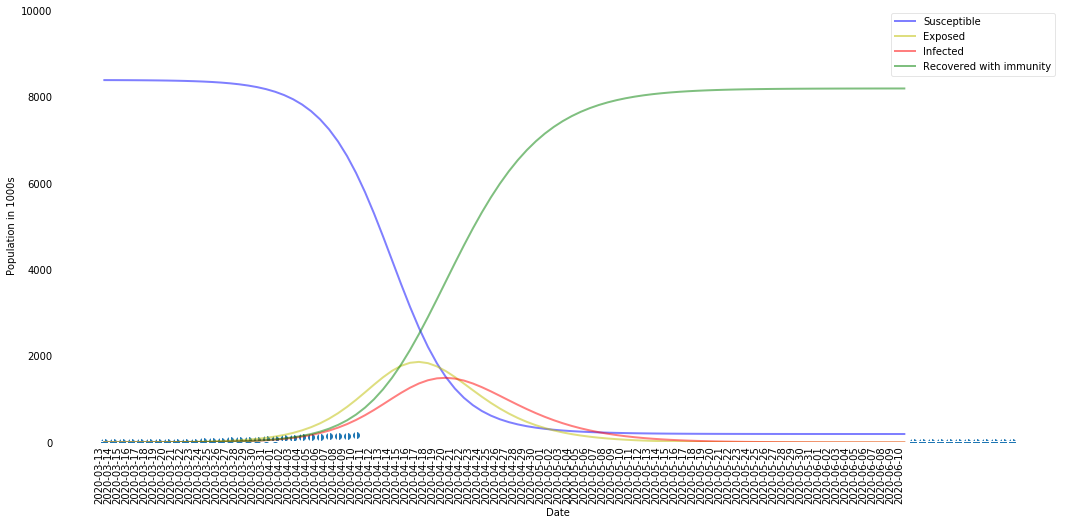

In [369]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot()
ax.plot(dates, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(dates, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(dates, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(dates, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.scatter(dates_real, state_covid.cases/1000)

ax.set_xticks(range(n_days),2)
ax.set_xticklabels([str(d.date()) for d in datelist], rotation = 90, ha="right")
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Date')
ax.set_ylabel(f'Population in {1000}s')
ax.set_ylim(0,population/1000 + 0.2*population/1000)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [373]:
# change parameters to death rate